In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [ ]:
!kaggle competitions download -c bike-sharing-demand

In [ ]:
!unzip bike-sharing-demand.zip

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.models import Model

In [5]:
# Load the Bike Sharing Demand dataset
df = pd.read_csv("train.csv")

In [6]:
# Preprocess the dataset (you may need to do more data cleaning and feature engineering)
df["datetime"] = pd.to_datetime(df["datetime"])
df["day_of_week"] = df["datetime"].dt.dayofweek
features = ["day_of_week", "temp", "humidity", "windspeed", "count"]
df = df[features]

In [7]:
# Split the dataset into training and testing sets
X = df.drop("count", axis=1)
y = df["count"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Scale numerical features
scaler_temp = StandardScaler()
scaler_humidity = StandardScaler()
scaler_windspeed = StandardScaler()

X_train[["temp"]] = scaler_temp.fit_transform(X_train[["temp"]])
X_train[["humidity"]] = scaler_humidity.fit_transform(X_train[["humidity"]])
X_train[["windspeed"]] = scaler_windspeed.fit_transform(X_train[["windspeed"]])

X_test[["temp"]] = scaler_temp.transform(X_test[["temp"]])
X_test[["humidity"]] = scaler_humidity.transform(X_test[["humidity"]])
X_test[["windspeed"]] = scaler_windspeed.transform(X_test[["windspeed"]])

In [10]:
# Scale target
m = y_train.max()
y_train = y_train /m
y_test = y_test /m

In [50]:
# Define input layers for categorical variables
input_day_of_week = Input(shape=(1,))

# Define embedding layers for categorical variables
embedding_dim = 3  # You can adjust this dimension
embedding_day_of_week = Embedding(input_dim=7, output_dim=embedding_dim)(input_day_of_week)  # 7 days in a week

# Flatten the embedding layer
flatten_day_of_week = Flatten()(embedding_day_of_week)

# Define input layer for numerical variables
input_numerical = Input(shape=(X_train.shape[1] - 1,))  # Minus 1 for the categorical input

# Concatenate all input layers
concatenated = concatenate([flatten_day_of_week, input_numerical])

# Build the model
x = Dense(64, activation="relu")(concatenated)
x = Dropout(0.5)(x)
output = Dense(1, activation="linear")(x)  # Linear activation for regression task

model = Model(inputs=[input_day_of_week, input_numerical], outputs=output)


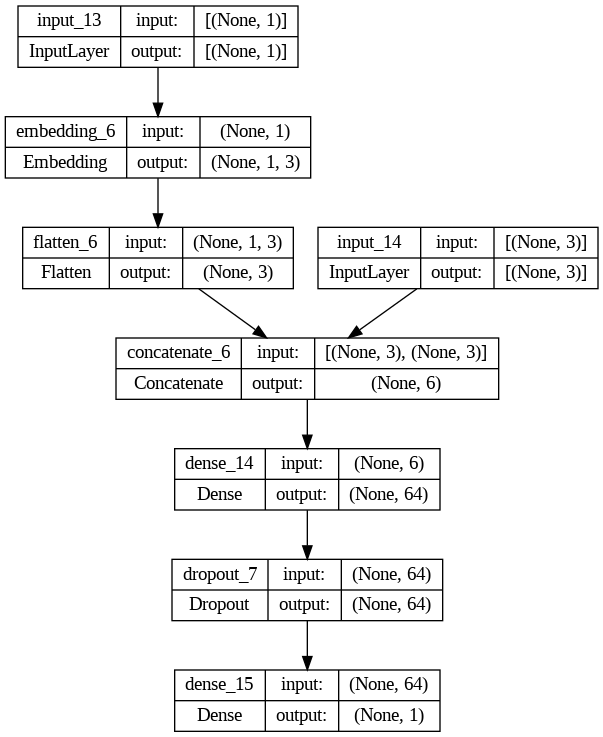

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [52]:
from keras.callbacks import ReduceLROnPlateau

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30)

# Compile the model
model.compile(optimizer="RMSprop", loss="mean_squared_error", metrics=["mae"])

# Train the model
h = model.fit(
    [X_train["day_of_week"], X_train[["temp", "humidity", "windspeed"]]],
    y_train,
    callbacks= [reduce_lr],
    epochs=300,
    batch_size=512,
    validation_split=0.1)

Epoch 1/300
16/16 [==============================] - 2s 21ms/step - loss: 0.1439 - mae: 0.2940 - val_loss: 0.0401 - val_mae: 0.1455 - lr: 0.0010
Epoch 2/300
16/16 [==============================] - 0s 8ms/step - loss: 0.1019 - mae: 0.2479 - val_loss: 0.0319 - val_mae: 0.1331 - lr: 0.0010
Epoch 3/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0799 - mae: 0.2188 - val_loss: 0.0297 - val_mae: 0.1295 - lr: 0.0010
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0658 - mae: 0.1965 - val_loss: 0.0289 - val_mae: 0.1277 - lr: 0.0010
Epoch 5/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0558 - mae: 0.1806 - val_loss: 0.0278 - val_mae: 0.1262 - lr: 0.0010
Epoch 6/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0465 - mae: 0.1654 - val_loss: 0.0273 - val_mae: 0.1249 - lr: 0.0010
Epoch 7/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0409 - mae: 0.1540 - val_loss: 0.0270 - val_mae: 0.1245 - lr

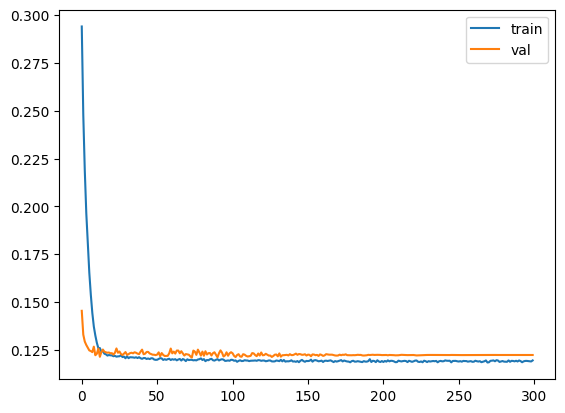

In [53]:
import matplotlib.pyplot as plt

plt.plot(h.history['mae'])
plt.plot(h.history['val_mae'])
plt.legend(["train", "val"])

In [59]:
# Evaluate the model
loss, mae = model.evaluate(
    [X_test["day_of_week"], X_test[["temp", "humidity", "windspeed"]]],
    y_test
)

print(f'Test Loss (MSE): {loss:.4f}')
print(f'Test MAE: {mae:.4f}')

69/69 [==============================] - 0s 2ms/step - loss: 0.0244 - mae: 0.1157
Test Loss (MSE): 0.0244
Test MAE: 0.1157


In [60]:
result = model.predict([X_test["day_of_week"], X_test[["temp", "humidity", "windspeed"]]])

69/69 [==============================] - 0s 2ms/step


In [61]:
[print(round(list(y_test)[i]*m) , round(result[i][0]*m)) for i in range(20)];

127 269
13 66
163 94
233 270
222 274
166 153
144 184
376 370
601 138
53 108
6 53
14 176
209 277
62 101
139 343
9 121
96 160
98 237
230 148
12 216


## Lets Visualize!

In [62]:
# Extract embeddings from the trained model
embedding_layer = model.layers[1]  # Assuming the embedding layer is the 2nd layer in your model
embedding_weights = embedding_layer.get_weights()[0]
embedding_weights.shape

(7, 3)

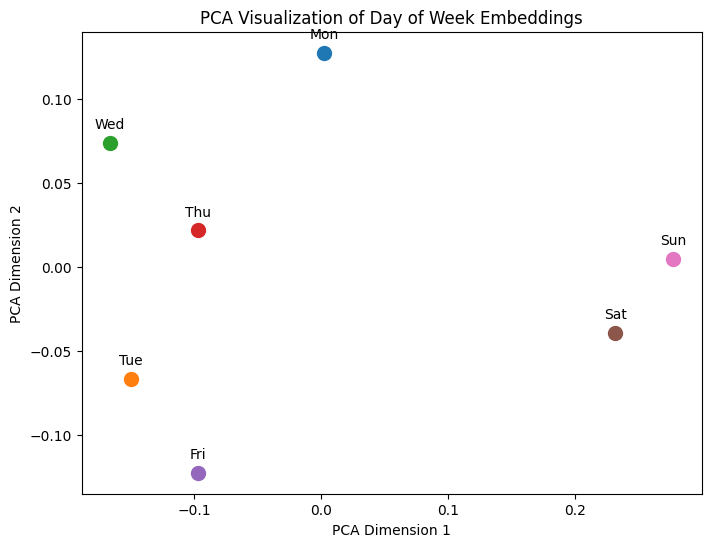

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Apply PCA to reduce embeddings to 2D space
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embedding_weights)

# Day labels
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Create a scatter plot with text labels
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(pca_embeddings):
    plt.scatter(x, y, s=100)
    plt.annotate(day_labels[i], (x, y), textcoords="offset points", xytext=(0, 10), ha="center")

plt.title("PCA Visualization of Day of Week Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()


https://class.vision